# Capstone Project
**Beibarys Nyussupov, Joseph Tadros, Luke Ducker**


This project assesses university professors using a large, publicly available dataset scraped from RateMyProfessor.com. The objective is to integrate core concepts from the course into a single applied analysis and to extract actionable insights about teaching quality and student perceptions. The dataset contains aggregated student ratings and related attributes for a broad sample of professors, with low individual response rates but substantial overall scale. Prior research reports a correlation of approximately 0.7 between RateMyProfessor ratings and official end-of-course teaching evaluations, which supports the analytical value of this source despite known response bias. All data collection and basic structuring steps were completed in advance, while data science-relevant preprocessing, including the identification and handling of missing data, was performed in this project. To address the research questions, appropriate statistical methods were selected based on underlying assumptions, with explicit justification provided throughout the report. Visualizations support interpretation and highlight key patterns in the data. All hypothesis testing uses α = 0.005 to reduce false positive findings (Habibzadeh, 2025). 


## Dataset description

### First dataset: `rmpCapstoneNum.csv`
Dataset contains 89893 records. Each of these
records (rows) corresponds to information about one professor. 

Columns:

`1: Average Rating (the arithmetic mean of all individual quality ratings of this professor)`

`2: Average Difficulty (the arithmetic mean of all individual difficulty ratings of this professor)`

`3: Number of ratings (simply the total number of ratings these averages are based on)`

`4: Received a “pepper”? (Boolean - was this professor judged as “hot” by the students?)`

`5: The proportion of students that said they would take the class again`

`6: The number of ratings coming from online classes`

`7: Male gender (Boolean – 1: determined with high confidence that professor is male)`

`8: Female (Boolean – 1: determined with high confidence that professor is female`


### Second dataset: ` rmpCapstoneQual.csv`
Dataset contains same 89893 records. 

Columns: 

`1: Major/Field`

`2: University`

`3: US State (2 letter abbreviation)`

### Third dataset: `rmpCapstoneTags.csv`
Dataset contains same 898393 records. 

The numbers in these columns correspond to the raw number of “tags” a professor has received. A student can award up to 3 such tags, but doesn’t have to award any. These tags are supposed to characterize the teaching style of the professor qualitatively, beyond ratings. 

Columns: 

`1: “Tough grader”`

`2: “Good feedback”`

`3: “Respected”`

`4: “Lots to read”`

`5: “Participation matters”`

`6: “Don’t skip class or you will not pass”`

`7: “Lots of homework”`

`8: “Inspirational”`

`9: “Pop quizzes!”`

`10: “Accessible”`

`11: “So many papers”`

`12: “Clear grading”`

`13: “Hilarious”`

`14: “Test heavy”`

`15: “Graded by few things”`

`16: “Amazing lectures”`

`17: “Caring”`

`18: “Extra credit”`

`19: “Group projects”`

`20: “Lecture heavy"`

In [1]:
# libraries 
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# statistical tests
from scipy import stats
import cliffs_delta

# reproducibility 
import random
# specify seed 
n_number = 12250697
random.seed(n_number)
np.random.seed(n_number)

In [2]:
# useful function
# simple significance test interpretation
def significance(alpha, p_value):
    """
    Decide based on alpha. 
    Note: p is the probability, under H0, of observing a statistic at least this extreme.

    """
    print(f"p-value: {p_value:.6g}")
    if p_value < alpha:
        print(f"p = {p_value:.6g} < α = {alpha} = Reject H0 (statistically significant).")
    else:
        print(f"p = {p_value:.6g} ≥ α = {alpha} = Fail to reject H0 (not statistically significant).")

## Pre-processing

In [4]:
# read and write locations
data_folder = os.path.join("..", "data")
raw_folder = os.path.join(data_folder, "raw")
processed_folder = os.path.join(data_folder, "processed")

# file names
rmp_num_filename = "rmpCapstoneNum.csv"
rmp_qual_filename = "rmpCapstoneQual.csv"
rmp_tags_filename = "rmpCapstoneTags.csv"

In [5]:
# import the data 

# import the data 
df_num = pd.read_csv(os.path.join(raw_folder, rmp_num_filename), header=None)
df_qual = pd.read_csv(os.path.join(raw_folder, rmp_qual_filename), header=None)
df_tags = pd.read_csv(os.path.join(raw_folder, rmp_tags_filename), header=None)

In [6]:
# headers for first dataset 
df_num_column_names = [
     "average_rating",
     "average_difficulty",
     "number_of_ratings",
     "received_a_pepper",
     "would_take_again",
     "number_of_ratings_online",
     "male_gender",
     "female_gender",
]

# headers for second dataset
df_qual_column_names = [
     "major",
     "university",
     "state",
]

# headers for third dataset 
df_tags_column_names = [
    "tough_grader",
    "good_feedback",
    "respected",
    "lots_to_read",
    "participation_matters",
    "dont_skip_class_or_you_will_not_pass",
    "lots_of_homework",
    "inspirational",
    "pop_quizzes",
    "accessible",
    "so_many_papers",
    "clear_grading",
    "hilarious",
    "test_heavy",
    "graded_by_few_things",
    "amazing_lectures",
    "caring",
    "extra_credit",
    "group_projects",
    "lecture_heavy"
]

# assign headers to dataframes using .columns attribute 
df_num.columns = df_num_column_names
df_qual.columns = df_qual_column_names
df_tags.columns = df_tags_column_names

In [7]:
# join the data for the easier manipulation 
df = df_num.join(df_qual).join(df_tags)

In [8]:
# check the data set (first five rows)
df.head()

,average_rating,average_difficulty,number_of_ratings,received_a_pepper,would_take_again,number_of_ratings_online,male_gender,female_gender,major,university,...,so_many_papers,clear_grading,hilarious,test_heavy,graded_by_few_things,amazing_lectures,caring,extra_credit,group_projects,lecture_heavy
0,5.0,1.5,2.0,0.0,NaN,0.0,0,1,Criminal Justice,George Mason University,...,0,0,0,0,0,0,0,0,0,1
1,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
2,3.2,3.0,4.0,0.0,NaN,0.0,1,0,English,Alabama State University,...,0,0,0,0,0,0,0,0,0,0
3,3.6,3.5,10.0,1.0,NaN,0.0,0,0,English,University of Kentucky,...,0,2,1,0,0,0,0,0,1,0
4,1.0,5.0,1.0,0.0,NaN,0.0,0,0,English,Keiser University,...,0,0,0,0,0,0,0,0,0,0


In [17]:
# information about the dataset 
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 70004 entries, 0 to 89891
Data columns (total 31 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   average_rating                        70004 non-null  float64
 1   average_difficulty                    70004 non-null  float64
 2   number_of_ratings                     70004 non-null  float64
 3   received_a_pepper                     70004 non-null  float64
 4   would_take_again                      12160 non-null  float64
 5   number_of_ratings_online              70004 non-null  float64
 6   male_gender                           70004 non-null  int64  
 7   female_gender                         70004 non-null  int64  
 8   major                                 70004 non-null  object 
 9   university                            70004 non-null  object 
 10  state                                 70004 non-null  object 
 11  tough_grader        

### Null Values

In [12]:
# check null values of the dataset by each column. 
df.isna().sum()

average_rating                          19889
average_difficulty                      19889
number_of_ratings                       19889
received_a_pepper                       19889
would_take_again                        77733
number_of_ratings_online                19889
male_gender                                 0
female_gender                               0
major                                   19889
university                              19889
state                                   19889
tough_grader                                0
good_feedback                               0
respected                                   0
lots_to_read                                0
participation_matters                       0
dont_skip_class_or_you_will_not_pass        0
lots_of_homework                            0
inspirational                               0
pop_quizzes                                 0
accessible                                  0
so_many_papers                    

A large block of missing data appears in the dataset. Exactly 19,889 records share missing values across all core numerical, categorical, and qualitative variables, with the exception of the “would take again” column. These missing values occur in the same row positions, which indicates a systematic issue rather than random missingness. In addition, all tag variables equal zero for these same records, which implies an absence of meaningful rating information rather than true zero-valued responses. Together, these patterns suggest these rows do not represent valid professor evaluations. Removing all 19,889 records is therefore justified, as retaining them would introduce noise and bias.

In [15]:
# drop null values from the dataset 
df = df.dropna(subset="average_rating")
# check the results
df.isna().sum()

average_rating                              0
average_difficulty                          0
number_of_ratings                           0
received_a_pepper                           0
would_take_again                        57844
number_of_ratings_online                    0
male_gender                                 0
female_gender                               0
major                                       0
university                                  0
state                                       0
tough_grader                                0
good_feedback                               0
respected                                   0
lots_to_read                                0
participation_matters                       0
dont_skip_class_or_you_will_not_pass        0
lots_of_homework                            0
inspirational                               0
pop_quizzes                                 0
accessible                                  0
so_many_papers                    

In [16]:
# check information about the dataset after removal 
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 70004 entries, 0 to 89891
Data columns (total 31 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   average_rating                        70004 non-null  float64
 1   average_difficulty                    70004 non-null  float64
 2   number_of_ratings                     70004 non-null  float64
 3   received_a_pepper                     70004 non-null  float64
 4   would_take_again                      12160 non-null  float64
 5   number_of_ratings_online              70004 non-null  float64
 6   male_gender                           70004 non-null  int64  
 7   female_gender                         70004 non-null  int64  
 8   major                                 70004 non-null  object 
 9   university                            70004 non-null  object 
 10  state                                 70004 non-null  object 
 11  tough_grader        

After removing the invalid records, the dataset contains 70,004 observations. The only remaining missing data is in the would_take_again variable, where a large proportion of values is missing. This variable is a bounded proportion, and the extent of missingness is too high for null values removal or imputation to be appropriate. Imputing values would impose artificial structure on a substantial share of the data and bias both estimates and inference. For this reason, we do not modify this column unless explicitly required. 

### Number of ratings threshold 
This section addresses the reliability of average professor ratings. An average rating based on very few student evaluations is unstable and can produce extreme values that do not reflect typical teaching quality. Professors with only one or two ratings are therefore not comparable to those evaluated by many students. To reduce noise and improve interpretability, an optimal number of ratings threshold is chosen and applied so that average ratings are computed and analyzed only when they are supported by a sufficient volume of observations. This choice reduces the influence of outliers driven by sparse data and ensures that comparisons across professors rely on more reliable estimates.

In [18]:
# distribution of number of ratings 
df["number_of_ratings"].describe()


count    70004.000000
mean         5.374721
std          8.136628
min          1.000000
25%          1.000000
50%          3.000000
75%          6.000000
max        393.000000
Name: number_of_ratings, dtype: float64

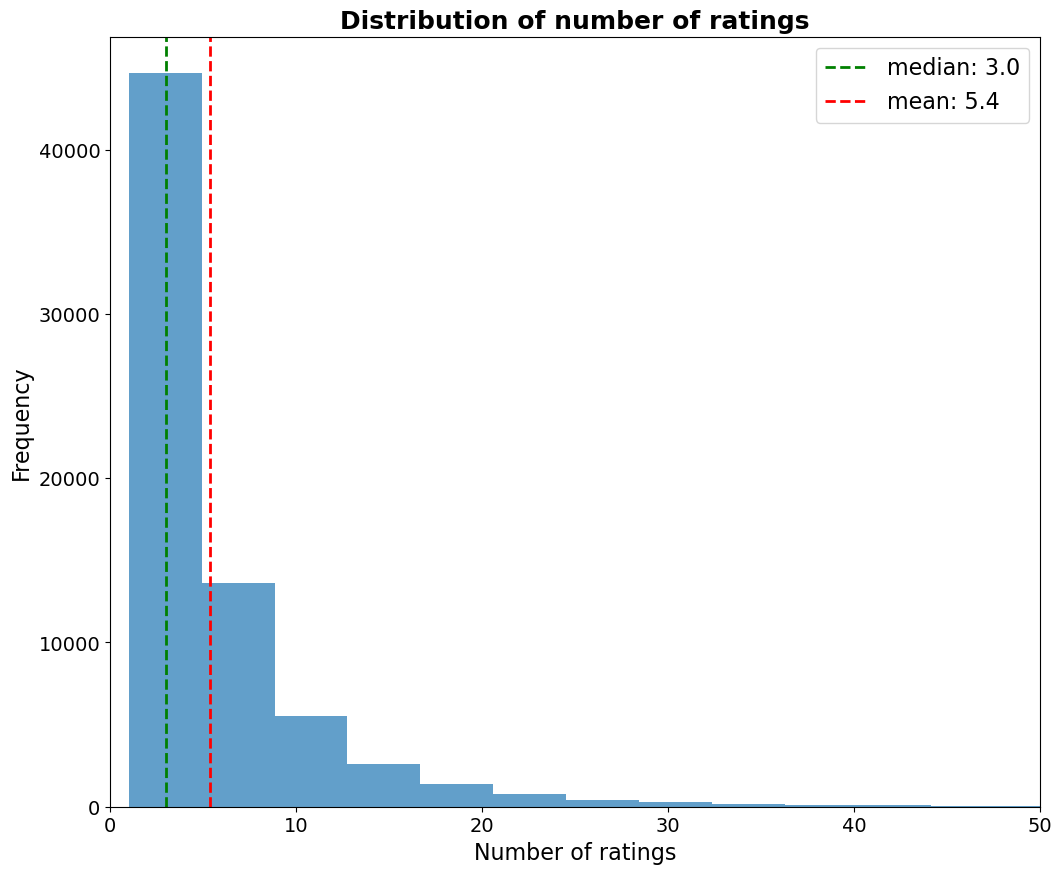

In [40]:
# plot for distribution of number of ratings 
plt.figure(figsize = (12, 10))

# histogram 
plt.hist(df["number_of_ratings"], 
         bins = 100, 
         alpha = 0.7)

# show median and mean value on the plot 
# median
plt.axvline(df["number_of_ratings"].median(), 
           color = "green", 
           linestyle = "dashed", 
           linewidth = 2, 
           label = f"median: {df['number_of_ratings'].median():.1f}")

# mean
plt.axvline(df["number_of_ratings"].mean(), 
           color = "red", 
           linestyle = "dashed", 
           linewidth = 2, 
           label= f"mean: {df['number_of_ratings'].mean():.1f}")

# aesthetics 
# title
plt.title("Distribution of number of ratings", 
          fontweight = "bold", 
          fontsize = 18)

# x axis 
plt.xlabel("Number of ratings", 
           fontsize = 16)
# limit
plt.xlim(0, 50)

# y axis
plt.ylabel("Frequency", 
           fontsize = 16)
# size for both x and y ticks 
plt.tick_params(axis = "both", 
                labelsize = 14)

# legend 
plt.legend(fontsize = 16)

# show the plot
plt.show()

In [41]:
# filter out the professors with less than 5 ratings
df_filtered = df[df["number_of_ratings"] >= 5].copy()

In [42]:
# check the distribution and information about the data after filter 
df_filtered["number_of_ratings"].describe()

count    25368.000000
mean        11.150662
std         11.327791
min          5.000000
25%          6.000000
50%          8.000000
75%         12.000000
max        393.000000
Name: number_of_ratings, dtype: float64

In [43]:
# info about the dataset 
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25368 entries, 3 to 89891
Data columns (total 31 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   average_rating                        25368 non-null  float64
 1   average_difficulty                    25368 non-null  float64
 2   number_of_ratings                     25368 non-null  float64
 3   received_a_pepper                     25368 non-null  float64
 4   would_take_again                      12160 non-null  float64
 5   number_of_ratings_online              25368 non-null  float64
 6   male_gender                           25368 non-null  int64  
 7   female_gender                         25368 non-null  int64  
 8   major                                 25368 non-null  object 
 9   university                            25368 non-null  object 
 10  state                                 25368 non-null  object 
 11  tough_grader        

The distribution of the number of ratings is highly right skewed, with a median of 3 and a mean of 5.4. Most professors receive only a small number of ratings, which leads to unstable and potentially extreme average values. To address this, we set a minimum threshold of five ratings and excluded professors with fewer than five evaluations. This cutoff is close to the mean and removes cases where average ratings are driven by very sparse data, while preserving the majority of the sample and improving the reliability of comparisons across professors. After applying this filter, 25,368 professors remain in the analysis dataset.

### Categorical variables 
In this section, we address the handling of categorical variables. Teaching style tags were normalized by dividing each tag count by the total number of tags received by a professor, converting raw counts into proportions. This normalization controls for differences in the total number of ratings and ensures that tag values are comparable across professors. Cases with no assigned tags resulted in undefined values after normalization and were set to zero, reflecting the absence of tag information rather than meaningful signal.

In addition, we examine the gender indicators provided in the dataset. The male and female variables are treated as categorical indicators.

In [44]:
# distribution of all tags before normalization 
# starting from 11th variable 
# .describe 
df_filtered.iloc[:, 11:].describe()

,tough_grader,good_feedback,respected,lots_to_read,participation_matters,dont_skip_class_or_you_will_not_pass,lots_of_homework,inspirational,pop_quizzes,accessible,so_many_papers,clear_grading,hilarious,test_heavy,graded_by_few_things,amazing_lectures,caring,extra_credit,group_projects,lecture_heavy
count,25368.000000,25368.000000,25368.000000,25368.000000,25368.000000,25368.000000,25368.000000,25368.000000,25368.000000,25368.000000,25368.000000,25368.000000,25368.000000,25368.000000,25368.000000,25368.000000,25368.000000,25368.000000,25368.000000,25368.000000
mean,2.036976,2.640374,1.920451,1.548841,1.778185,1.838261,1.600047,1.216809,0.393843,0.827854,0.286187,1.505401,1.420293,0.385722,0.336447,1.423329,2.358050,1.159256,0.533783,1.094056
std,3.279020,4.120596,3.634944,2.718146,2.903643,2.988417,3.058181,2.803210,1.420362,1.794848,0.943474,2.408472,3.664116,1.241309,0.854666,3.159003,3.540912,2.935454,1.661896,1.981580
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,3.000000,3.000000,3.000000,2.000000,2.000000,2.250000,2.000000,1.000000,0.000000,1.000000,0.000000,2.000000,2.000000,0.000000,0.000000,2.000000,3.000000,1.000000,0.000000,1.000000
max,112.000000,171.000000,186.000000,82.000000,82.000000,110.000000,141.000000,119.000000,97.000000,63.000000,64.000000,77.000000,224.000000,81.000000,39.000000,136.000000,127.000000,128.000000,92.000000,38.000000


In [45]:
# calculate total # of tags for each professor
total_tag_counts = df_filtered[df_tags_column_names].sum(axis = 1)

# normalize tag columns to be between 0 and 1 by dividing tag counts by total tag counts
for col in df_tags_column_names:
    df_filtered[col] = df_filtered[col] / total_tag_counts

# fill na values with 0 that resulted from divide by zero issues
df_filtered[df_tags_column_names] = df_filtered[df_tags_column_names].fillna(0)

In [46]:
# look at the distribution of tags after the normalization 
df_filtered.iloc[:, 11:].describe()

,tough_grader,good_feedback,respected,lots_to_read,participation_matters,dont_skip_class_or_you_will_not_pass,lots_of_homework,inspirational,pop_quizzes,accessible,so_many_papers,clear_grading,hilarious,test_heavy,graded_by_few_things,amazing_lectures,caring,extra_credit,group_projects,lecture_heavy
count,25368.000000,25368.000000,25368.000000,25368.000000,25368.000000,25368.000000,25368.000000,25368.000000,25368.000000,25368.000000,25368.000000,25368.000000,25368.000000,25368.000000,25368.000000,25368.000000,25368.000000,25368.000000,25368.000000,25368.000000
mean,0.085069,0.100868,0.068629,0.062054,0.069651,0.069879,0.064489,0.041886,0.015234,0.028761,0.012109,0.058709,0.049038,0.013922,0.014433,0.047059,0.088719,0.041532,0.021918,0.045526
std,0.107520,0.091155,0.074261,0.084513,0.078161,0.078915,0.086387,0.061327,0.044127,0.045961,0.034345,0.067916,0.075274,0.035435,0.035939,0.064779,0.082976,0.068912,0.052664,0.071531
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.021277,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.047619,0.083333,0.055556,0.025000,0.052632,0.052632,0.029168,0.000000,0.000000,0.000000,0.000000,0.044776,0.000000,0.000000,0.000000,0.000000,0.074074,0.000000,0.000000,0.000000
75%,0.136364,0.153846,0.111111,0.100000,0.111111,0.111111,0.100000,0.068966,0.000000,0.050000,0.000000,0.090909,0.076923,0.000000,0.000000,0.076923,0.142857,0.065217,0.000000,0.071429
max,1.000000,1.000000,0.600000,1.000000,1.000000,1.000000,1.000000,0.500000,0.500000,0.666667,0.500000,0.666667,0.625000,1.000000,0.500000,0.666667,1.000000,0.862069,0.545455,1.000000


Now, we are looking at gender variables. 

In [48]:
# check male and female gender error, where both are 1, or both 0
both_11 = df_filtered[(df_filtered["male_gender"] == 1) & (df_filtered["female_gender"] == 1)].shape[0]
both_00 = df_filtered[(df_filtered["male_gender"] == 0) & (df_filtered["female_gender"] == 0)].shape[0]

# print the results 
print(f"Number of professors with both male and female gender as 1: {both_11}")
print(f"Number of professors with both male and female gender as 0: {both_00}")

Number of professors with both male and female gender as 1: 776
Number of professors with both male and female gender as 0: 6170


This is a clear data error and should be removed. 

In [49]:
# drop rows where both male and female gender are 1 or 0
df_filtered_final = df_filtered[~((df_filtered["male_gender"] == 1) & (df_filtered["female_gender"] == 1)) & 
                          (~((df_filtered["male_gender"] == 0) & (df_filtered["female_gender"] == 0)))].copy()

# check the results
df_filtered_final.info()


<class 'pandas.core.frame.DataFrame'>
Index: 18422 entries, 5 to 89890
Data columns (total 31 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   average_rating                        18422 non-null  float64
 1   average_difficulty                    18422 non-null  float64
 2   number_of_ratings                     18422 non-null  float64
 3   received_a_pepper                     18422 non-null  float64
 4   would_take_again                      8849 non-null   float64
 5   number_of_ratings_online              18422 non-null  float64
 6   male_gender                           18422 non-null  int64  
 7   female_gender                         18422 non-null  int64  
 8   major                                 18422 non-null  object 
 9   university                            18422 non-null  object 
 10  state                                 18422 non-null  object 
 11  tough_grader        

After data pre-processing, we are left with ~18k rows. Now we will proceed answering research questions. 

## Q1. Activists have asserted that there is a strong gender bias in student evaluations of professors, with male professors enjoying a boost in rating from this bias...We would like you to answer the question whether there is evidence of a pro-male gender bias in this dataset.


In [90]:
# separate the average ratings into two groups based on gender
# Male = 1, Male = 0
df1_male = df_filtered_final[df_filtered_final["male_gender"] == 1]
df1_female = df_filtered_final[df_filtered_final["male_gender"] == 0]

In [91]:
# count number of professors in each group
print(f"Number of male professors: {df1_male.shape[0]}")
print(f"Number of female professors: {df1_female.shape[0]}")

Number of male professors: 10015
Number of female professors: 8407


A difference is noticeable, but not very large. We can proceed with the analysis. 

C:\Users\nyuss\AppData\Local\Temp\ipykernel_24076\2381853625.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_filtered_final,


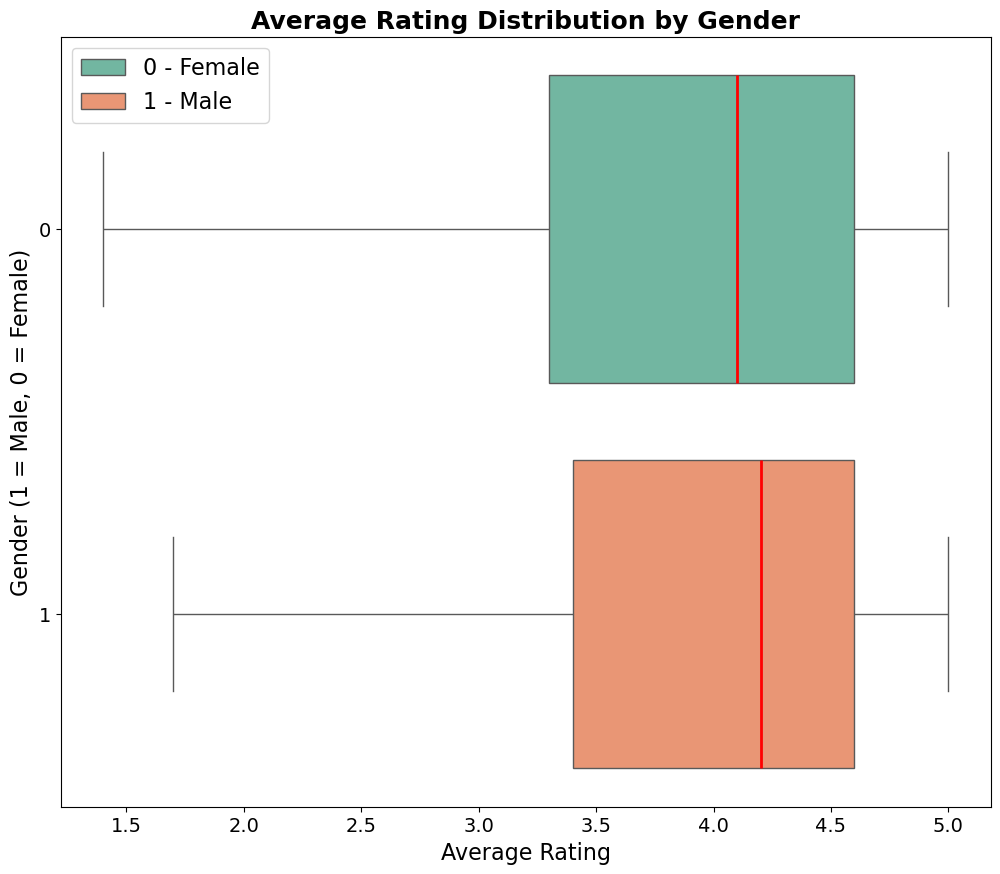

In [77]:
# compare distributions of average rating between male and female professors
plt.figure(figsize=(12, 10))

# box plot for male and female professors 
sns.boxplot(data=df_filtered_final, 
            x='average_rating', 
            y='male_gender', 
            palette = "Set2", 
            showfliers = False, 
            medianprops = {"color": "red", "linewidth": 2}, 
            orient= "horizontal")

# aesthetics 
plt.title('Average Rating Distribution by Gender', 
          fontweight = "bold",
          fontsize = 18)

# xlabel
plt.xlabel('Average Rating', 
           fontsize = 16)
# ylabel
plt.ylabel('Gender (1 = Male, 0 = Female)', 
           fontsize = 16)

# legend
plt.legend(['0 - Female', 
            '1 - Male'], 
            fontsize = 16,
           loc = "upper left")
# ticks 
plt.tick_params(axis = "both", 
                labelsize = 14)

plt.show()

The boxplot suggests a small difference in average ratings by gender. The distributions for male and female professors overlap substantially, but the male distribution appears slightly shifted to the right, with a higher median average rating. The spread of ratings is similar across genders, indicating comparable variability. To further test the difference, we have to apply a significance test. 

Using average ratings separated by gender, we test whether male professors receive higher average ratings than female professors. 

We use a one-tailed Mann-Whitney U test to compare average ratings by gender. This test is appropriate because average ratings are ordinal and non-normal. 

`Null hypothesis (H0):` Average ratings for male professors are not different than average ratings of female professors.

`Alternative hypothesis (Ha):` Average ratings for male professors are significantly higher than those for female professors.

`Significance level:` 0.005

If the p-value is smaller than 0.005, it means such a result would be very unlikely by chance under the null hypothesis, so we reject the H0 and conclude that average ratings for male professors are significantly higher than those for female professors. 

If the p-value is larger than 0.005, then the observed difference could easily occur by random variation, so we fail to reject the H0, meaning data does not provide enough statistical evidence to conclude that average ratings differ. 

In [84]:
# conduct mann-whitney u test for average rating using our function
u_stat, p_value = stats.mannwhitneyu(df1_male['average_rating'], 
                                     df1_female['average_rating'], 
                                     alternative='greater')
# interpretation 
significance(0.005, p_value)


p-value: 0.00024523
p = 0.00024523 < α = 0.005 = Reject H0 (statistically significant).


Our p-value (0.00024523) is smaller than 0.005, so we reject the Null Hypothesis and conclude that average ratings for male professors are significantly higher than for female professors. It does not mean that we found an evidence of pro-male ratings bias, as our data is not randomized and we are not controlling for all confounders. However we found a statistical evidence that average ratings of male professors are higher. 

## Q2. Is there a gender difference in the spread (variance/dispersion) of the ratings distribution? Again, it is advisable to consider the statistical significance of any observed gender differences in this sprea

In [93]:
# again_separate the average ratings into two groups based on gender
# Male = 1, Male = 0
df2_male = df_filtered_final[df_filtered_final["male_gender"] == 1]
df2_female = df_filtered_final[df_filtered_final["male_gender"] == 0]

In [94]:
# count number of professors in each group
print(f"Number of male professors: {df2_male.shape[0]}")
print(f"Number of female professors: {df2_female.shape[0]}")


Number of male professors: 10015
Number of female professors: 8407


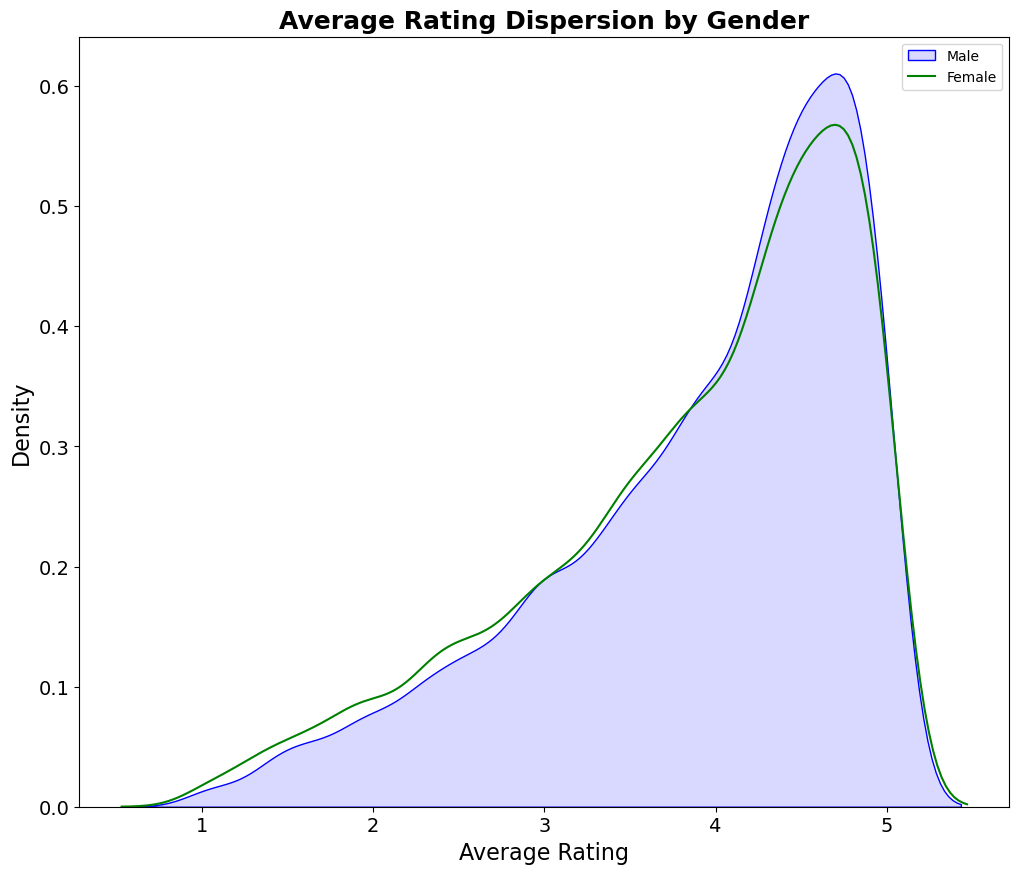

In [120]:
# plot the variance of average rating dipersion between male and female professors
# kernel density plot 
plt.figure(figsize=(12, 10))

# plot
sns.kdeplot(df2_male['average_rating'], 
           label='Male', 
           color='blue', 
           fill=True, 
           legend= True, 
           alpha=0.15
           )
sns.kdeplot(df2_female['average_rating'],
              label='Female', 
              color='green', 
              fill=False, 
              legend= True)

# aesthetics
plt.title('Average Rating Dispersion by Gender', 
          fontweight = "bold",
          fontsize = 18)
# xlabel
plt.xlabel('Average Rating',
              fontsize = 16)
# ylabel
plt.ylabel('Density',
                fontsize = 16)

# axis 
plt.tick_params(axis = "both", 
                labelsize = 14)
# legend 
plt.legend()
# ticks
plt.show()

The density curves for average ratings by gender are highly similar, indicating comparable dispersion across male and female professors. Both distributions span a similar range and show similar tail behavior, which suggests no large difference in variability. The male distribution is slightly shifted to the right, consistent with higher average ratings, but the overall spread and shape of the two distributions closely align. Viisually we can not observe any significant and/or major differences in variance. 

In order to test the dispersion of average ratings by gender, we use two-tailed Levene's test with a median function. Levene's test is appropriate for average ratings, since it is robust to normality violations, and able to utilize both median and mean metrics for comparison. 

`Null hypothesis (H0):` Average ratings dispersion of male professors is not different than of female professors.  

`Alternative hypothesis (Ha):` Average ratings dispersion of male professors is significantly different than of female professors. 

`Significance level:` 0.005

If the p-value is smaller than 0.005, it means such a result would be very unlikely by chance under the null hypothesis, so we reject the H0 and conclude that there is a significant difference in dispersion of average ratings by 2 gender groups. 

If the p-value is larger than 0.005, then the observed difference could easily occur by random variation, so we fail to reject the H0, meaning data does not provide enough statistical evidence to conclude that there is a significant dispersion difference. 


In [123]:
# dispersion of average ratings 
# levene's test for equal variances
levene_stat, levene_p_value = stats.levene(df2_male['average_rating'], 
                                      df2_female['average_rating'], 
                                      center='median')

# check the result 
significance(0.005, levene_p_value)

p-value: 5.97717e-06
p = 5.97717e-06 < α = 0.005 = Reject H0 (statistically significant).


Our p-value (5.97717e-06) is significantly smaller than 0.005, which means that our observed data is unlikely to appear by chance and there is a significant difference in dispersion of male and female professors' average ratings. 

## 3. What is the likely size of both of these effects (gender bias in average rating, gender bias in spread of average rating), as estimated from this dataset? Please use 95% confidence and make sure to report each/both. 

In [57]:
# computing effect size for average rating distribution by gender using cliffs_delta
effect_size = cliffs_delta.cliffs_delta(df2_male['average_rating'], df2_female['average_rating'])
print(f"Effect size (Cliffs Delta): {effect_size}")


Effect size (Cliffs Delta): (0.08551949719792877, 'negligible')


In [66]:
# Bootstrap 95% CI for Cliff’s delta (clean, non-hardcoded)

import numpy as np
from scipy.stats import bootstrap
from cliffs_delta import cliffs_delta as cd

# split data by gender
male = df2_male["average_rating"].to_numpy()
female = df2_female["average_rating"].to_numpy()

# statistic for scipy.bootstrap
def stat_cliffs(x, y, axis=0):
    # cd returns a tuple; first element is the numeric delta
    return cd(x, y)[0]

# bootstrap CI
res = bootstrap(
    data=(male, female),
    statistic=stat_cliffs,
    confidence_level=0.95,
    n_resamples=5000,
    method="percentile",
    vectorized=False,
    random_state=42
)

# point estimate
d_hat = cd(male, female)[0]

print("Cliff’s delta:", d_hat)
print("95% CI:", (res.confidence_interval.low, res.confidence_interval.high))


Cliff’s delta: 0.08551949719792877
95% CI: (0.07004540616044445, 0.10104824362413348)
